In [25]:
# import pacakges
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# import datasets
calendar = pd.read_csv("~/Downloads/berlin-airbnb-data/calendar_summary.csv")
listing = pd.read_csv("~/Downloads/berlin-airbnb-data/listings_summary.csv")

In [3]:
calendar.head()

,listing_id,date,available,price
0,2015,2019-09-10,f,NaN
1,2015,2019-09-09,f,NaN
2,2015,2019-09-08,f,NaN
3,2015,2019-09-07,f,NaN
4,2015,2019-09-06,f,NaN


In [4]:
# delete rows with price = N/A (unavailable housings)
calendar = calendar.dropna()

In [5]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800841 entries, 128 to 8231474
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         object
dtypes: int64(1), object(3)
memory usage: 68.7+ MB


In [6]:
# change date from object to date, price to numeric
calendar['date'] = pd.to_datetime(calendar['date'])
calendar[['price']] = calendar[['price']].replace('[\$,]','',regex=True).astype(float)

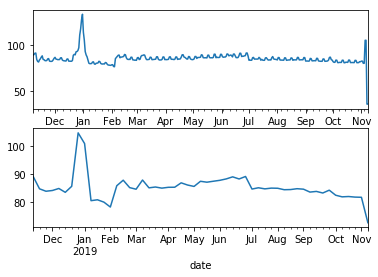

In [7]:
calendar_price = calendar.groupby(['date'])['price'].mean()
plt.subplot(211)
calendar_price.resample('D').mean().plot()
plt.subplot(212)
calendar_price.resample('W').mean().plot()

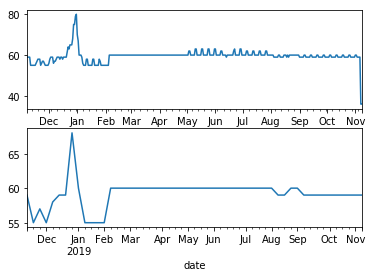

In [9]:
# Check robustness with median
calendar_price = calendar.groupby(['date'])['price'].median()
plt.subplot(211)
calendar_price.resample('D').median().plot()
plt.subplot(212)
calendar_price.resample('W').median().plot()

In [10]:
# import more packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

In [26]:
# explore listings_summary table to predict the price of a airbnb property
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [30]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
id                                  22552 non-null int64
listing_url                         22552 non-null object
scrape_id                           22552 non-null int64
last_scraped                        22552 non-null object
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
thumbnail_url           

In [105]:
# drop some useless columns and keep columns that I thought make sense
keep_columns = ['id', 'price', 'cleaning_fee', 'description', 'experiences_offered', 'host_id', 
               'host_is_superhost', 'host_listings_count','host_identity_verified', 'neighbourhood_group_cleansed',
               'market', 'smart_location', 'is_location_exact', 'property_type', 'room_type', 'accommodates',
               'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'number_of_reviews',
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value','instant_bookable', 
                'is_business_travel_ready', 'cancellation_policy', 'reviews_per_month']

df_listings = listing[keep_columns].set_index('id')

In [106]:
df_listings.head()

,price,cleaning_fee,description,experiences_offered,host_id,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_group_cleansed,market,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
2015,$60.00,$30.00,Great location! 30 of 75 sq meters. This wood...,none,2217,t,4.0,t,Mitte,Berlin,...,10.0,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,3.76
2695,$17.00,$0.00,In the summertime we are spending most of our ...,none,2986,f,1.0,t,Pankow,Berlin,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,1.42
3176,$90.00,$50.00,This beautiful first floor apartment is situa...,none,3718,f,1.0,t,Pankow,Berlin,...,9.0,9.0,9.0,9.0,10.0,9.0,t,f,strict_14_with_grace_period,1.25
3309,$26.00,$30.00,First of all: I prefer short-notice bookings. ...,none,4108,f,1.0,t,Tempelhof - Schöneberg,Berlin,...,9.0,9.0,9.0,10.0,9.0,9.0,f,f,strict_14_with_grace_period,0.39
7071,$42.00,$0.00,Cozy and large room in the beautiful district ...,none,17391,t,1.0,t,Pankow,Berlin,...,10.0,10.0,10.0,10.0,10.0,9.0,f,f,moderate,1.75


In [128]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22552 entries, 2015 to 29867352
Data columns (total 38 columns):
price                           22552 non-null float64
cleaning_fee                    22552 non-null float64
description                     22349 non-null object
experiences_offered             22552 non-null object
host_id                         22552 non-null int64
host_is_superhost               22526 non-null object
host_listings_count             22526 non-null float64
host_identity_verified          22526 non-null object
neighbourhood_group_cleansed    22552 non-null object
market                          22552 non-null object
smart_location                  22552 non-null object
is_location_exact               22552 non-null object
property_type                   22552 non-null object
room_type                       22552 non-null object
accommodates                    22552 non-null int64
bathrooms                       22520 non-null float64
bedrooms           

In [108]:
# fill in the null
df_listings['market'].fillna(df_listings['market'].mode, inplace = True) # replace with mode
df_listings['cleaning_fee'].fillna('$0.00', inplace = True) # replace null with $0.00

In [109]:
# change objects into numeric
df_listings.price = df_listings.price.str.replace('$', '').str.replace(',', '').astype(float)
df_listings.cleaning_fee = df_listings.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_listings.extra_people = df_listings.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

(array([1.000e+00, 4.000e+00, 8.000e+01, 3.440e+02, 1.052e+03, 7.740e+02,
        1.849e+03, 2.073e+03, 1.750e+03, 1.982e+03, 5.270e+02, 1.263e+03,
        1.782e+03, 8.320e+02, 1.282e+03, 1.730e+02, 6.740e+02, 8.970e+02,
        4.910e+02, 7.750e+02, 8.000e+01, 3.230e+02, 4.960e+02, 2.620e+02,
        6.430e+02, 3.000e+01, 7.100e+01, 1.850e+02, 6.200e+01, 3.130e+02,
        1.400e+01, 7.100e+01, 1.500e+02, 4.100e+01, 1.000e+02, 5.000e+00,
        4.400e+01, 2.250e+02, 2.300e+01, 6.200e+01, 1.000e+00, 1.700e+01,
        4.900e+01, 1.500e+01, 6.400e+01, 3.000e+00, 1.700e+01, 3.200e+01,
        1.700e+01, 1.120e+02, 1.000e+00, 1.000e+00, 1.400e+01, 9.000e+00,
        2.000e+01, 4.000e+00, 7.000e+00, 1.000e+01, 7.000e+00, 2.600e+01,
        4.000e+00, 4.000e+00, 5.800e+01, 4.000e+00, 8.000e+00, 2.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 1.500e+01, 0.000e+00, 2.000e+00,
        6.000e+00, 2.000e+00, 3.200e+01, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.000e+00, 0.000e+0

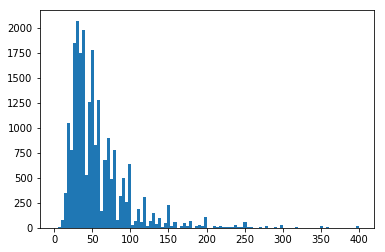

In [157]:
# EDA
plt.hist(df_listings.price, bins = 100)
# the distribution is right skewed and there are outliers whose price is incrediblily high

In [156]:
df_listings.price.describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [155]:
# drop those outliers
df_listings.drop(df_listings[(df_listings.price > 400) | (df_listings.price == 0) ].index, axis=0, inplace=True)

In [159]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 2015 to 29867352
Data columns (total 38 columns):
price                           22441 non-null float64
cleaning_fee                    22441 non-null float64
description                     22239 non-null object
experiences_offered             22441 non-null object
host_id                         22441 non-null int64
host_is_superhost               22416 non-null object
host_listings_count             22416 non-null float64
host_identity_verified          22416 non-null object
neighbourhood_group_cleansed    22441 non-null object
market                          22441 non-null object
smart_location                  22441 non-null object
is_location_exact               22441 non-null object
property_type                   22441 non-null object
room_type                       22441 non-null object
accommodates                    22441 non-null int64
bathrooms                       22409 non-null float64
bedrooms           

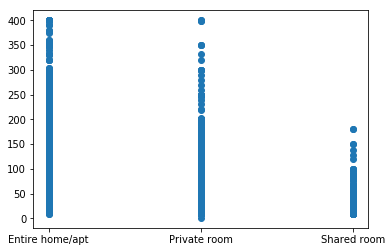

In [158]:
plt.scatter(df_listings.room_type, df_listings.price)

(array([1.8271e+04, 1.9490e+03, 8.3600e+02, 4.8400e+02, 3.1100e+02,
        1.9900e+02, 1.2800e+02, 8.6000e+01, 5.3000e+01, 3.2000e+01,
        3.0000e+01, 1.9000e+01, 1.4000e+01, 4.0000e+00, 1.1000e+01,
        6.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([  0. ,  24.9,  49.8,  74.7,  99.6, 124.5, 149.4, 174.3, 199.2,
        224.1, 249. , 273.9, 298.8, 323.7, 348.6, 373.5, 398.4, 423.3,
        448.2, 473.1, 498. ]),
 <a list of 20 Patch objects>)

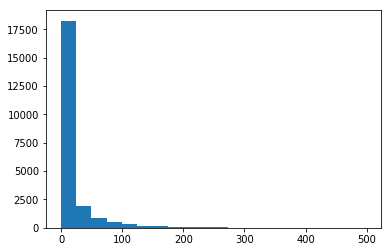

In [160]:
plt.hist(df_listings.number_of_reviews, bins=20)

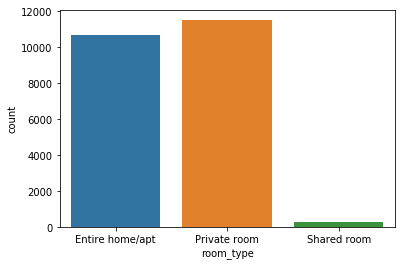

In [162]:
sns.countplot('room_type', data = df_listings)

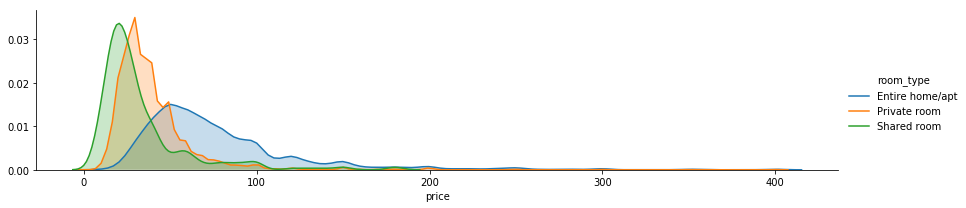

In [163]:
fig = sns.FacetGrid(df_listings, hue = 'room_type', aspect=4)
fig.map(sns.kdeplot, 'price', shade=True)
fig.add_legend()

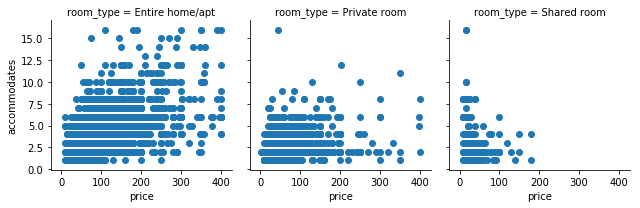

<Figure size 720x864 with 0 Axes>

In [164]:
g = sns.FacetGrid(df_listings, col="room_type")
g = g.map(plt.scatter, "price", "accommodates")
figure = plt.figure(figsize = (10, 12))

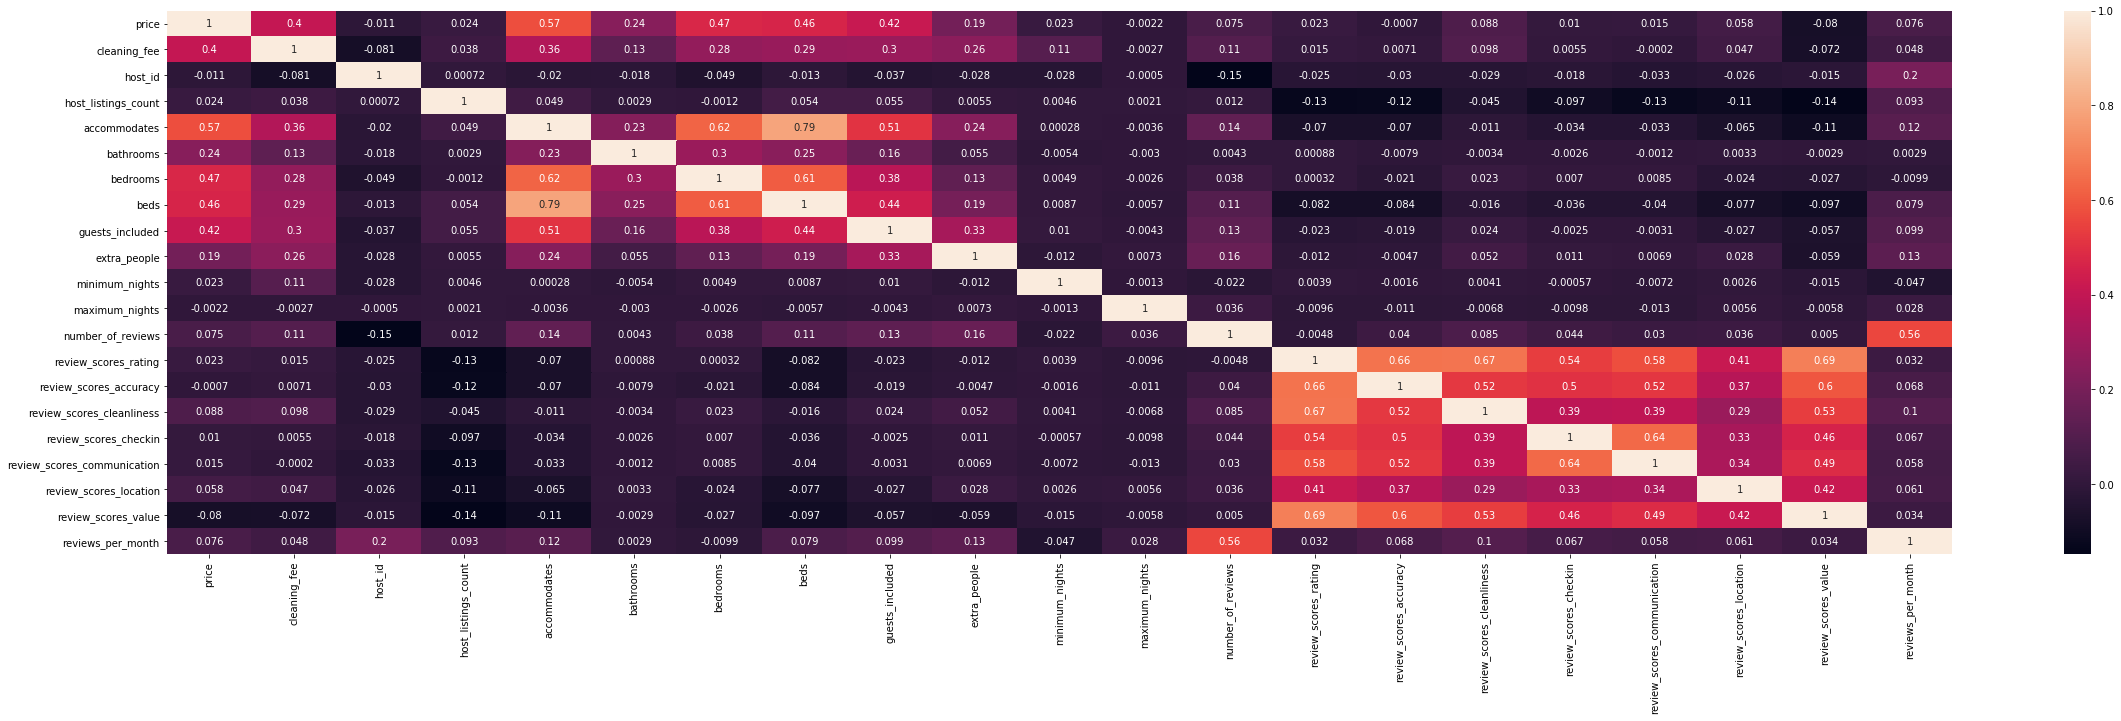

In [168]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
corr = df_listings.select_dtypes(include=numerics).corr()
ax = sns.heatmap(corr, annot = True)
from pylab import rcParams
rcParams['figure.figsize'] = 80, 30

In [184]:
# devide X into 2 lists: numeric and categorical types
numX = df_listings.select_dtypes(include=['float64', 'int64', 'bool'])
numX = numX.fillna(numX.mean())
numX = numX.drop(columns = ['host_id'])

catX = df_listings.select_dtypes(include=['object'])
catX = catX.drop(columns = ['description', 'amenities', 'market', 'smart_location'])
catX = catX.apply(lambda col: col.fillna(col.mode()[0]),axis=1)
catX = pd.get_dummies(catX)

In [185]:
catX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 2015 to 29867352
Columns: 144 entries, experiences_offered_none to cancellation_policy_super_strict_60
dtypes: uint8(144)
memory usage: 3.9 MB


In [186]:
numX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 2015 to 29867352
Data columns (total 20 columns):
price                          22441 non-null float64
cleaning_fee                   22441 non-null float64
host_listings_count            22441 non-null float64
accommodates                   22441 non-null int64
bathrooms                      22441 non-null float64
bedrooms                       22441 non-null float64
beds                           22441 non-null float64
guests_included                22441 non-null int64
extra_people                   22441 non-null float64
minimum_nights                 22441 non-null int64
maximum_nights                 22441 non-null int64
number_of_reviews              22441 non-null int64
review_scores_rating           22441 non-null float64
review_scores_accuracy         22441 non-null float64
review_scores_cleanliness      22441 non-null float64
review_scores_checkin          22441 non-null float64
review_scores_communication    

In [189]:
df_listings2 = pd.concat([numX, catX], axis=1)

In [190]:
df_listings2.shape

(22441, 164)

In [191]:
# scaled the data and then use random forest regressor fo the prediction.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_listings2)
rescaledX = scaler.transform(df_listings2)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


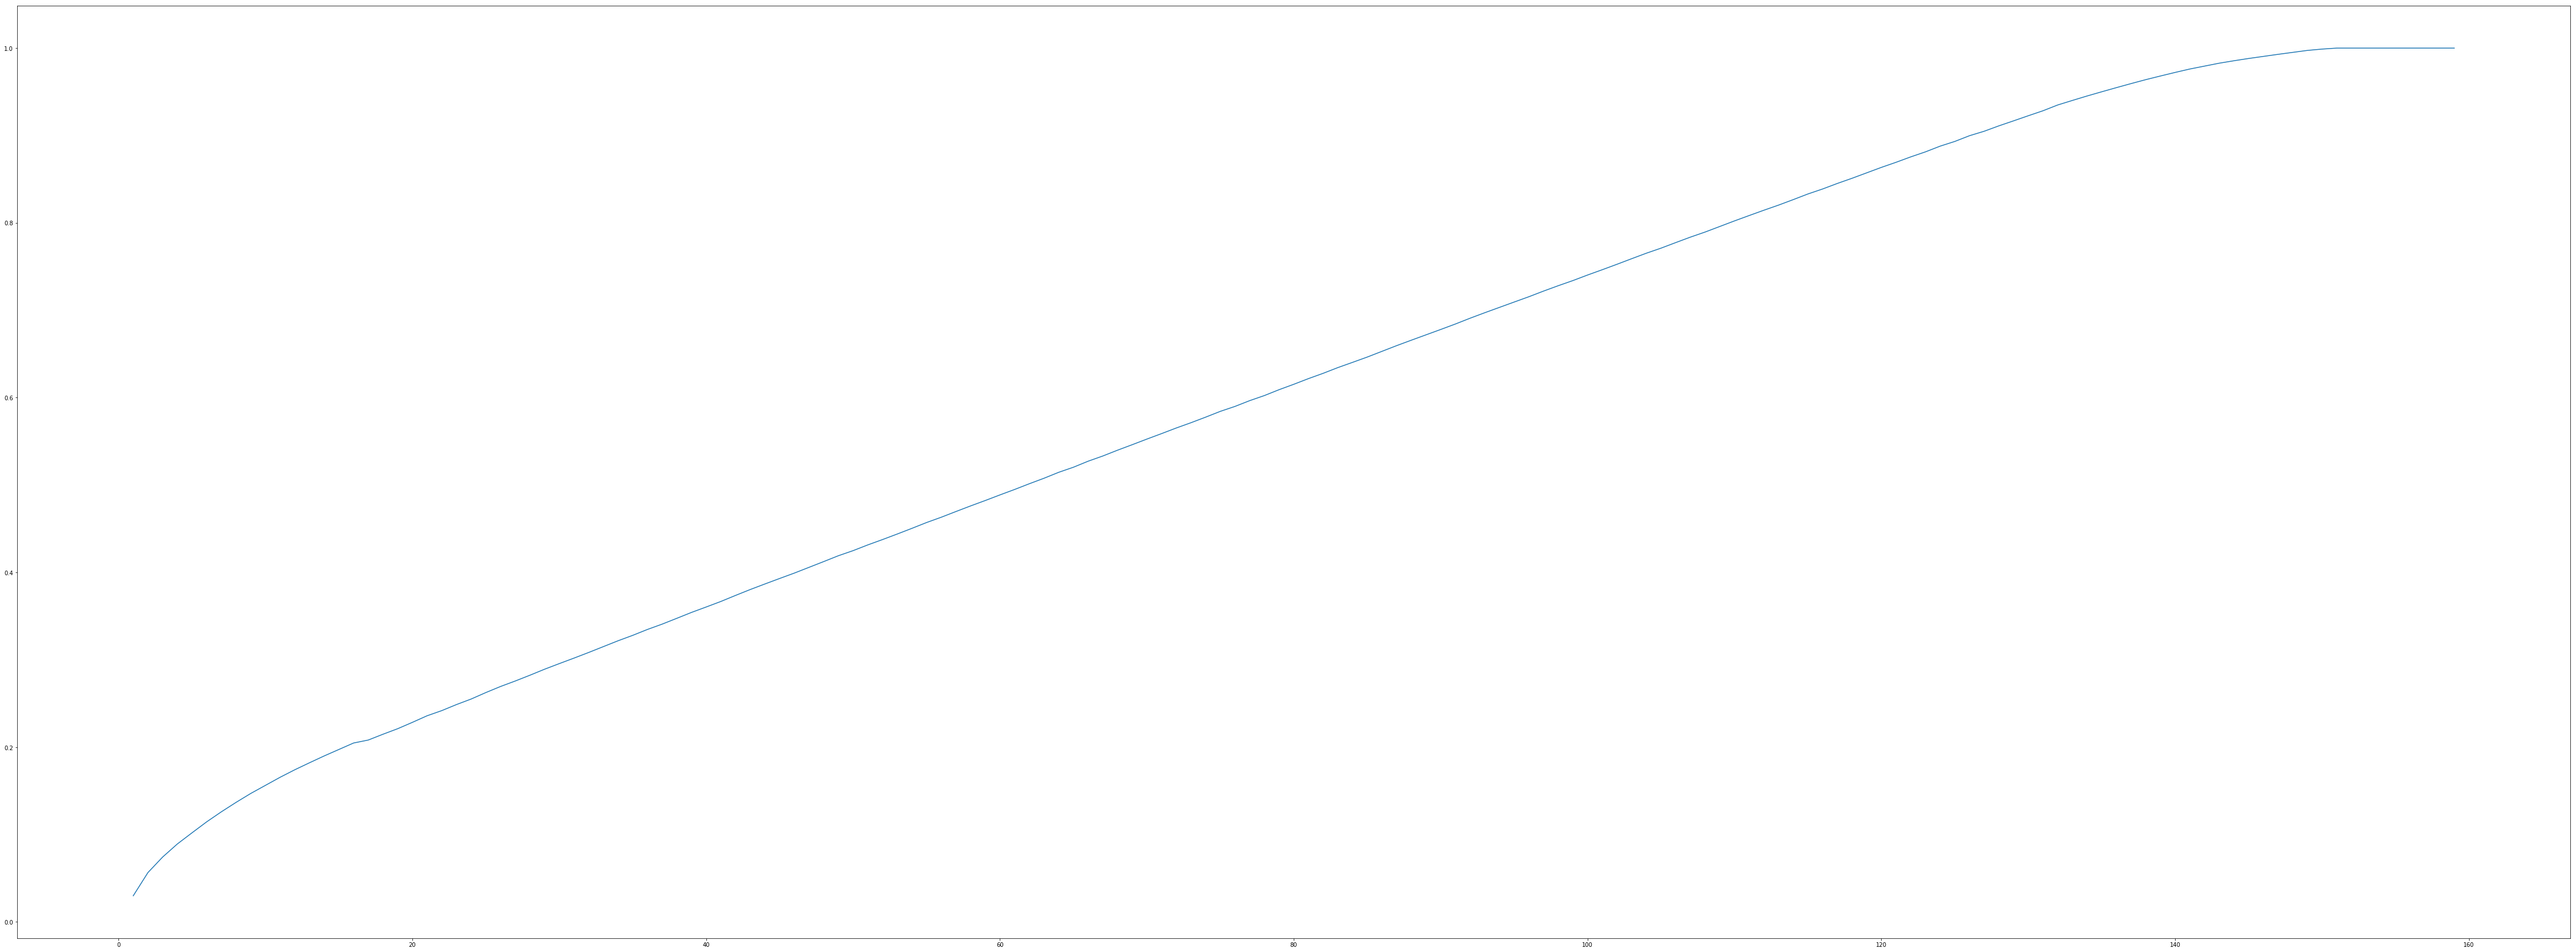

In [193]:
from sklearn.decomposition import PCA
explained_var = list()
for i in range(1,160):
    pca = PCA(n_components=i)
    pca.fit(rescaledX)
    explained_var.append(pca.explained_variance_ratio_.sum())
x = np.arange(1, 160)
expained_var = np.array(explained_var)
plt.plot(x,explained_var)

rcParams['figure.figsize'] = 30, 10

In [136]:
pca = PCA(n_components=100) 
pca.fit(rescaledX)
pcadata = pca.fit_transform(rescaledX)
pca.explained_variance_ratio_.sum()

0.7410753910484773

In [137]:
X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=100)
lnmodel = LinearRegression(normalize=True)
lnmodel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [138]:
y_test_pred = lnmodel.predict(X_test)
y_train_pred = lnmodel.predict(X_train)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 37752.330, test: 49045.892
R^2 train: 0.175, test: 0.136


In [139]:
def model_perf(Xdata,component_low,component_high,model):
    mse_train = list()
    mse_test = list()
    r2_train = list()
    r2_test = list()
    for i in range(component_low,component_high):
        pca = PCA(n_components=i) 
        pca.fit(Xdata)
        pcadata = pca.fit_transform(Xdata)
        X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=42)
        model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
    x = range(component_low,component_high)
    plt.plot(x,mse_train,color='black')
    plt.plot(x,mse_test,color='blue')
    plt.show()

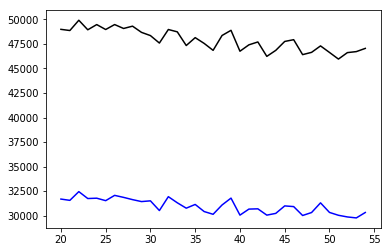

In [140]:
lnmodel = LinearRegression(normalize=True)
model_perf(rescaledX,20,55,lnmodel)

In [194]:
rfmodel = RandomForestRegressor(n_estimators = 100, max_depth = 10, oob_score=True, random_state=42)
rfmodel.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)